(target-platform-paper-social-analysis-pt1)=
# Platform paper social experiment analysis: Part 1

In this guide we will work with data collected from experiments `social0.2` and `social0.4`, in which two mice foraged for food in the [habitat](target-habitat) with three [foraging patches](target-foraging-patch) whose reward rates changed dynamically over time. 

The experiments each consist of three periods:

1. "presocial", in which each mouse was in the habitat alone for 3-4 days.
2. "social", in which both mice were in the habitat together for 2 weeks.
3. "postsocial", in which each mouse was in the habitat alone again for 3-4 days.

The goal of the experiments was to understand how the mice's behaviour changes as they learn to forage for food in the habitat, and how their behaviour differs between solo and social settings.

The full datasets are available on the [Datasets](target-full-datasets) page, but for the purpose of this guide, we will be using the precomputed [Platform paper social analysis datasets](target-precomputed-datasets).

:::{seealso}
- [](target-dj-compute-behav-bouts) for examples of how we precompute these datasets.
- "Extended Data Fig. 7", in "Extended Data" in the "Supplementary Material" of the [platform paper](aeon-paper:) for a detailed description of the experiments.
:::

Below is a brief explanation of how the environment (i.e. patch properties) changed over {term}`blocks <Block>` (60&ndash;180 minute periods of time):

1. Every block begins at a random interval $t$:

    $$
    t \sim \mathrm{Uniform}(60,\,180) \quad \text{In minutes}
    $$
2. At the start of each block, sample a row from the predefined matrix $\lambda_{\mathrm{set}}$:

    $$
    \lambda_{\mathrm{set}} = 
    \begin{pmatrix}
    1 & 1 & 1 \\
    5 & 5 & 5 \\
    1 & 3 & 5 \\
    1 & 5 & 3 \\
    3 & 1 & 5 \\
    3 & 5 & 1 \\
    5 & 1 & 3 \\
    5 & 3 & 1 \\
    \end{pmatrix}
    \quad \text{In meters}
    $$
3. Assign the sampled row to specific patch means $\lambda_{\mathrm{1}}, \lambda_{\mathrm{2}}, \lambda_{\mathrm{3}}$ and apply a constant offset $c$ to all thresholds:

    $$
    \begin{aligned}
    \lambda_{\mathrm{1}}, \lambda_{\mathrm{2}}, \lambda_{\mathrm{3}} &\sim \mathrm{Uniform}(\lambda_{\mathrm{set}}) \\
    c &= 0.75
    \end{aligned}
    \quad \text{Patch means and offset}
    $$
4. Sample a value from each of $P_{\mathrm{1}}, P_{\mathrm{2}}, P_{\mathrm{3}}$ as the initial threshold for the respective patch. Whenever a patch reaches its threshold, resample a new value from its corresponding distribution:

    $$
    \begin{aligned}
    P_{\mathrm{1}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{1}}) \\
    P_{\mathrm{2}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{2}}) \\
    P_{\mathrm{3}} &= c + \mathrm{Exp}(1/\lambda_{\mathrm{3}})
    \end{aligned}
    \quad \text{Patch distributions}
    $$

## Set up environment

Create and activate a virtual environment named `social-analysis` using [uv](https://docs.astral.sh/uv/getting-started/installation/).
```bash
uv venv aeon-social-analysis --python ">=3.11" 
source aeon-social-analysis/bin/activate   # Unix
.\aeon-social-analysis\Scripts\activate   # Windows
```

Install the required dependencies.
```bash
uv pip install matplotlib numpy pandas seaborn statsmodels pyyaml pyarrow tqdm scipy jupyter
```

## Import libraries and define variables and helper functions

In [1]:
import math
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import binomtest, ttest_rel, wilcoxon
from tqdm.notebook import tqdm

The hidden cells below define helper functions, constants, and setup variables used throughout the notebook. 
They **must be run**, but are hidden for readability.  

In [ ]:
# Plot settings
sns.set_style("ticks")
# Constants
cm2px = 5.2  # 1 cm = 5.2 px roughly in aeon habitats
light_off, light_on = 7, 20  # 7am to 8pm
fps = 50  # frames per second for tracking camera
# Experiment timelines
experiments = [
    {
        "name": "social0.2-aeon3",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 16:00:00",
        "social_end": "2024-02-23 13:00:00",
        "postsocial_start": "2024-02-25 17:00:00",
        "postsocial_end": "2024-03-02 14:00:00",
    },
    {
        "name": "social0.2-aeon4",
        "presocial_start": "2024-01-31 11:00:00",
        "presocial_end": "2024-02-08 15:00:00",
        "social_start": "2024-02-09 17:00:00",
        "social_end": "2024-02-23 12:00:00",
        "postsocial_start": "2024-02-25 18:00:00",
        "postsocial_end": "2024-03-02 13:00:00",
    },
    {
        "name": "social0.4-aeon3",
        "presocial_start": "2024-08-16 17:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 11:00:00",
        "social_end": "2024-09-09 13:00:00",
        "postsocial_start": "2024-09-09 18:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
    {
        "name": "social0.4-aeon4",
        "presocial_start": "2024-08-16 15:00:00",
        "presocial_end": "2024-08-24 10:00:00",
        "social_start": "2024-08-28 10:00:00",
        "social_end": "2024-09-09 01:00:00",
        "postsocial_start": "2024-09-09 15:00:00",
        "postsocial_end": "2024-09-22 16:00:00",
    },
]

In [ ]:
def load_data_from_parquet(
    experiment_name: str | None,
    period: str | None,
    data_type: str,
    data_dir: Path,
    set_time_index: bool = False,
) -> pd.DataFrame:
    """Loads saved data from parquet files.

    Args:
        experiment_name (str, optional): Filter by experiment name. If None, load all experiments.
        period (str, optional): Filter by period (presocial, social, postsocial). If None, load all periods.
        data_type (str): Type of data to load (position, patch, foraging, rfid, sleep, explore)
        data_dir (Path): Directory containing parquet files.
        set_time_index (bool, optional): If True, set 'time' column as DataFrame index.

    Returns:
        pd.DataFrame: Combined DataFrame of all matching parquet files.
    """
    if not data_dir.exists():
        print(f"Directory {data_dir} does not exist. No data files found.")
        return pd.DataFrame()
    # Create pattern based on filters
    pattern = ""
    if experiment_name:
        pattern += f"{experiment_name}_"
    else:
        pattern += "*_"
    if period:
        pattern += f"{period}_"
    else:
        pattern += "*_"
    pattern += f"{data_type}.parquet"
    # Find matching files
    matching_files = list(data_dir.glob(pattern))
    if not matching_files:
        print(f"No matching data files found with pattern: {pattern}")
        return pd.DataFrame()
    print(f"Found {len(matching_files)} matching files")
    # Load and concatenate matching files
    dfs = []
    total_rows = 0
    for file in matching_files:
        print(f"Loading {file}...")
        df = pd.read_parquet(file)
        total_rows += len(df)
        dfs.append(df)
        print(f"  Loaded {len(df)} rows")
    # Combine data
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        if set_time_index and "time" in combined_df.columns:
            combined_df = combined_df.set_index("time")
        print(f"Combined data: {len(combined_df)} rows")
        return combined_df
    else:
        return pd.DataFrame()


def load_experiment_data(
    data_dir: Path,
    experiment: dict | None = None,
    periods: list | None = None,
    data_types: list[str] = ["rfid", "position"],
    trim_days: int | None = None,
) -> dict:
    """Load all data types for specified periods of an experiment.

    Parameters:
    - experiment: experiment dict with period start/end times
    - periods: list of periods to load
    - data_types: list of data types to load
    - data_dir: directory containing data files
    - trim_days: Optional number of days to trim from start (None = no trim)

    Returns:
    - Dictionary containing dataframes for each period/data type combination
    """
    result = {}
    if periods is None:
        periods = [None]
    for period in periods:
        for data_type in data_types:
            print(f"Loading {period} {data_type} data...")
            # Load data
            experiment_name = experiment["name"] if experiment is not None else None
            df = load_data_from_parquet(
                experiment_name=experiment_name,
                period=period,
                data_type=data_type,
                data_dir=data_dir,
                set_time_index=(data_type == "position"),
            )
            # Trim if requested
            if trim_days is not None and len(df) > 0:
                if data_type == "rfid":
                    start_time = df["chunk_start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["chunk_start"] < end_time]
                if data_type == "foraging":
                    start_time = df["start"].min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df[df["start"] < end_time]
                if data_type == "position":
                    start_time = df.index.min()
                    end_time = start_time + pd.Timedelta(days=trim_days)
                    df = df.loc[df.index < end_time]
                print(f"  Trimmed to {trim_days} days: {len(df)} records")
            # Store in result
            key = f"{period}_{data_type}"
            result[key] = df
            # For position data, handle duplicates
            if data_type == "position" and len(df) > 0:
                original_len = len(df)
                df = df.reset_index()
                df = df.drop_duplicates(subset=["time", "identity_name"])
                df = df.set_index("time")
                result[key] = df
                if len(df) < original_len:
                    print(f"  Removed duplicates: {original_len} -> {len(df)}")
    return result


def patch_info_df_to_dict(df: pd.DataFrame) -> dict:
    """Convert patch information DataFrame to nested dictionary format.

    Parameters:
    - df: DataFrame containing patch information with columns ['experiment_name', 'block_start', 'patch_name', 'patch_rate', 'patch_offset']

    Returns:
    - Dictionary with experiments as keys and lists of patch entries as values
    """
    result_dict = {}
    for _, row in df.iterrows():
        exp = row["experiment_name"]
        # Initialize experiment entry if it doesn't exist
        if exp not in result_dict:
            result_dict[exp] = []
        # Create entry dictionary
        entry = {
            "block_start": row["block_start"].to_pydatetime(),
            "patch_name": row["patch_name"],
            "patch_rate": row["patch_rate"],
            "patch_offset": row["patch_offset"],
        }
        # Add entry to experiment list
        result_dict[exp].append(entry)
    return result_dict


def patch_df_to_dict(df: pd.DataFrame) -> dict:
    """Convert patch DataFrame to dictionary grouped by experiment.

    Parameters:
    - df: DataFrame containing patch data with 'experiment_name' column

    Returns:
    - Dictionary with experiment names as keys and filtered DataFrames as values
    """
    results_dict = {}
    for experiment in df["experiment_name"].unique():
        # Filter the dataframe to only include rows for this experiment
        experiment_df = df[df["experiment_name"] == experiment].copy()
        # Remove unwanted columns
        experiment_df = experiment_df.drop(columns=["experiment_name"])
        # Assign the filtered DataFrame directly to the dictionary
        results_dict[experiment] = experiment_df
    return results_dict


def get_first_half_social(df: pd.DataFrame) -> pd.DataFrame:
    """Extract the first half of social period data for each experiment.

    Parameters:
    - df: DataFrame containing experiment data with 'period' and 'experiment_name' columns

    Returns:
    - DataFrame containing first half of social data for all experiments
    """
    # Get social data
    social_data = df[df["period"] == "social"]
    # Group social data by experiment
    social_by_exp = social_data.groupby("experiment_name")
    # For each experiment, take the first half of social data
    half_social_data_list = []
    for _exp_name, exp_data in social_by_exp:
        # Sort by block_start to ensure chronological order
        exp_data_sorted = exp_data.sort_values("block_start")
        # Calculate the half-point
        half_point = len(exp_data_sorted) // 2
        # Take the first half
        first_half = exp_data_sorted.iloc[:half_point]
        # Add to list
        half_social_data_list.append(first_half)
    # Combine all first halves into one dataframe
    half_social_data = (
        pd.concat(half_social_data_list)
        if half_social_data_list
        else pd.DataFrame(columns=social_data.columns)
    )
    return half_social_data


def compute_patch_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    """Compute patch probabilities based on block and subject data.

    Parameters:
    - df: DataFrame containing block, subject, pellet, and patch data

    Returns:
    - DataFrame with probabilities for each patch per pellet interval
    """
    results = []
    # Precompute unique block-subject groups
    grouped_data = df.groupby(["block_start", "subject_name"])
    for (block_start, subject_name), block_data in grouped_data:
        # Process pellet timestamps once
        # Extract and ensure all pellet timestamps are float
        all_pellet_timestamps = []
        for sublist in block_data["pellet_timestamps"]:
            for ts in sublist:
                try:
                    all_pellet_timestamps.append(float(ts))
                except (ValueError, TypeError):
                    # Skip values that can't be converted to float
                    pass
        pellet_timestamps = np.sort(np.unique(all_pellet_timestamps))
        if len(pellet_timestamps) < 2:
            continue
        # Create pellet intervals DataFrame
        intervals_df = pd.DataFrame(
            {
                "interval_start": pellet_timestamps[:-1],
                "interval_end": pellet_timestamps[1:],
                "pellet_number": np.arange(1, len(pellet_timestamps)),
            }
        )
        # Prepare a dict to hold in_patch_timestamps for each patch
        patches_data = {}
        for patch in block_data["patch_name"].unique():
            patch_data = block_data[block_data["patch_name"] == patch]
            if patch_data.shape[0] != 1:
                raise ValueError(
                    "More than one row per block start, subject, patch combination."
                )
            # Get timestamps and ensure they're floats
            in_patch_ts_raw = patch_data.iloc[0]["in_patch_timestamps"]
            in_patch_timestamps = []
            for ts in in_patch_ts_raw:
                try:
                    in_patch_timestamps.append(float(ts))
                except (ValueError, TypeError):
                    # Skip values that can't be converted to float
                    pass
            patches_data[patch] = np.sort(np.array(in_patch_timestamps))
        # Initialize a DataFrame to store counts per patch
        counts_df = intervals_df[["pellet_number"]].copy()
        # For each patch, compute counts within each interval using numpy searchsorted
        for patch, in_patch_ts in patches_data.items():
            counts = np.zeros(len(intervals_df), dtype=int)
            if len(in_patch_ts) > 0:
                # Convert to float arrays explicitly
                in_patch_ts = in_patch_ts.astype(np.float64)
                interval_starts = intervals_df["interval_start"].values.astype(
                    np.float64
                )
                interval_ends = intervals_df["interval_end"].values.astype(np.float64)
                idx_start = np.searchsorted(in_patch_ts, interval_starts, side="left")
                idx_end = np.searchsorted(in_patch_ts, interval_ends, side="right")
                counts = idx_end - idx_start
            counts_df[f"count_in_{patch}"] = counts
        # Compute total counts per interval
        counts_df["total_counts"] = counts_df.filter(like="count_in_").sum(axis=1)
        # Avoid division by zero
        counts_df["total_counts"] = counts_df["total_counts"].replace(0, np.nan)
        # Compute probabilities per interval
        for idx, row in counts_df.iterrows():
            pellet_number = row["pellet_number"]
            row_data = {
                "block_start": block_start,
                "subject_name": subject_name,
                "pellet_number": pellet_number,
            }
            ts_in_patches = {
                patch: row[f"count_in_{patch}"] for patch in patches_data.keys()
            }
            ts_in_patches_total = row["total_counts"]
            if pd.isna(ts_in_patches_total):
                prob = {patch: 0 for patch in ts_in_patches.keys()}
            else:
                prob = {
                    patch: ts_in_patches[patch] / ts_in_patches_total
                    for patch in ts_in_patches.keys()
                }
            row_data.update(
                {f"prob_in_{patch}": prob[patch] for patch in patches_data.keys()}
            )
            results.append(row_data)
    # Create final DataFrame
    prob_per_patch = pd.DataFrame(results)
    return prob_per_patch


def extract_hard_patch_probabilities(
    prob_per_patch: pd.DataFrame,
    patch_info: List[Dict[str, Any]],
    patch_rate: float = 0.002,
) -> pd.DataFrame:
    """Extract probabilities for hard patches matching specified patch rate.

    Parameters:
    - prob_per_patch: DataFrame containing probabilities per patch
    - patch_info: List of dictionaries with patch information
    - patch_rate: Patch rate to filter by (default: 0.002)

    Returns:
    - DataFrame with probabilities for each hard patch
    """
    # Filter the hard patches based on the patch_rate
    hard_patches = [
        patch_dict
        for patch_dict in patch_info
        if patch_dict["patch_rate"] == patch_rate
    ]
    results = []
    for hard_patch in hard_patches:
        block_start = hard_patch["block_start"]
        patch_name = hard_patch["patch_name"]
        # Extract the hard patch data
        hard_patch_data = prob_per_patch.loc[
            prob_per_patch["block_start"] == block_start,
            ["block_start", "subject_name", "pellet_number", f"prob_in_{patch_name}"],
        ]
        hard_patch_data = hard_patch_data.rename(
            columns={f"prob_in_{patch_name}": "prob_in_hard_patch"}
        )
        results.append(hard_patch_data)
    # Concatenate all results into a single DataFrame
    prob_hard_patch = pd.concat(results, ignore_index=True)
    return prob_hard_patch


def analyze_patch_probabilities(
    data: pd.DataFrame, label: str
) -> Tuple[sm.OLS, np.ndarray]:
    """Analyze patch probabilities using linear regression model.

    Parameters:
    - data: DataFrame containing pellet_number and prob_in_hard_patch columns
    - label: Label for the analysis output

    Returns:
    - Tuple of (fitted OLS model, predicted values array)
    """
    # Prepare the data for statsmodels (add a constant for the intercept)
    X = np.array(data["pellet_number"][0:35])
    y = np.array(data["prob_in_hard_patch"][0:35])
    # Add a constant to the independent variable X to calculate the intercept
    X_with_constant = sm.add_constant(X)
    # Fit the model using statsmodels
    model = sm.OLS(y, X_with_constant).fit()
    y_pred = model.predict(X_with_constant)
    # Get the p-value for the slope
    p_value = model.pvalues[1]
    print(f"P-value for the {label} slope: {p_value}")
    # Print full statistical summary
    print(f"{label} model summary: ", model.summary())
    return model, y_pred


In [ ]:
# CHANGE THIS TO THE PATH WHERE
# YOUR LOCAL DATASET (PARQUET FILES) IS STORED
data_dir = Path("")

## Dominance

Using position and orientation data from [multi-animal tracking](target-multianimal-tracking) of pose and identity, we identify social encounters and retreats. 
These events form the basis of the _automated tube test_: by considering all automatically scored encounters and retreats, we infer hierarchical relationships across experiments, producing continuous, time-resolved rankings from the most subordinate to the most dominant subjects.

### Load data

In [ ]:
social_retreat_df_all_exps = []
social_fight_df_all_exps = []
social_patchinfo_df_all_exps = []
social_patch_df_all_exps = []

pbar = tqdm(
    experiments,
    desc="Loading experiments",
    unit="experiment",
)
for exp in pbar:
    data = load_experiment_data(
        experiment=exp,
        data_dir=data_dir,
        periods=["social"],
        data_types=["retreat", "fight", "patchinfo", "patch"],
        # trim_days=1  # Optional: trim
    )
    df_retreat = data["social_retreat"]
    df_fight = data["social_fight"]
    social_patchinfo_df = data["social_patchinfo"]
    social_patch_df = data["social_patch"]
    df_retreat["experiment_name"] = exp["name"]
    df_fight["experiment_name"] = exp["name"]
    social_retreat_df_all_exps.append(df_retreat)
    social_fight_df_all_exps.append(df_fight)
    social_patchinfo_df_all_exps.append(social_patchinfo_df)
    social_patch_df_all_exps.append(social_patch_df)

social_retreat_df_all_exps = pd.concat(social_retreat_df_all_exps, ignore_index=True)
social_fight_df_all_exps = pd.concat(social_fight_df_all_exps, ignore_index=True)
social_patchinfo_df_all_exps = pd.concat(
    social_patchinfo_df_all_exps, ignore_index=True
)
social_patch_df_all_exps = pd.concat(social_patch_df_all_exps, ignore_index=True)

### Fights and retreats

Aligned Day 0 starts at hour 10
Global end at Day 14, hour 1


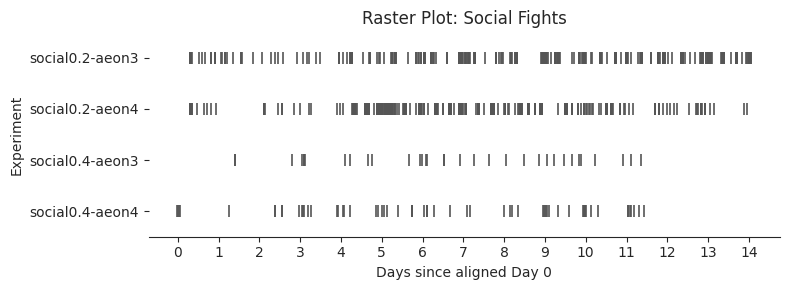

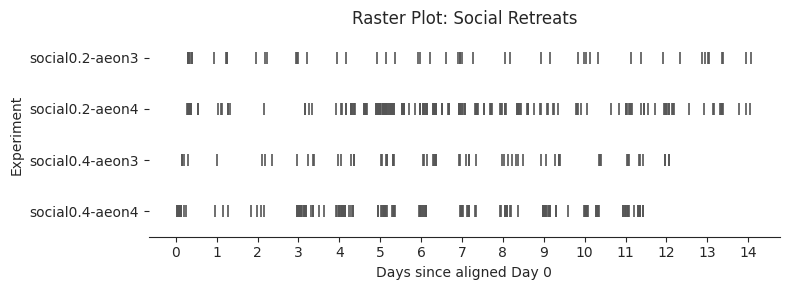

In [6]:
# Build lookup of social_start & compute per-exp offset to align at earliest start-time
exp_df = pd.DataFrame(experiments)
exp_df["social_start"] = pd.to_datetime(exp_df["social_start"])
exp_df["tod_sec"] = (
    exp_df["social_start"].dt.hour * 3600
    + exp_df["social_start"].dt.minute * 60
    + exp_df["social_start"].dt.second
)
# Earliest start-time (seconds since midnight)
min_tod = exp_df["tod_sec"].min()
# Offset seconds so each experiment’s Day 0 lines up at min_tod
exp_df["offset_sec"] = exp_df["tod_sec"] - min_tod
# Compute absolute baseline timestamp per experiment
exp_df["baseline_ts"] = exp_df["social_start"] - pd.to_timedelta(
    exp_df["offset_sec"], unit="s"
)
exp_df = exp_df[["name", "baseline_ts"]]
# Print aligned Day 0 hour (earliest start-time)
aligned_hour = min_tod // 3600
print(f"Aligned Day 0 starts at hour {aligned_hour}")

# Compute global end time across both datasets
all_events = pd.concat(
    [
        social_fight_df_all_exps[["experiment_name", "start_timestamp"]],
        social_retreat_df_all_exps[["experiment_name", "start_timestamp"]],
    ]
)
all_events["start_timestamp"] = pd.to_datetime(all_events["start_timestamp"])
# Merge baseline timestamps
all_events = all_events.merge(
    exp_df, left_on="experiment_name", right_on="name", how="left"
)
# Compute seconds since baseline
all_events["rel_sec"] = (
    all_events["start_timestamp"] - all_events["baseline_ts"]
).dt.total_seconds()
# Find last event
last = all_events.loc[all_events["rel_sec"].idxmax()]
# Compute end day and hour
end_day = int(last["rel_sec"] // 86400)
end_hour = int((last["rel_sec"] % 86400) // 3600)
print(f"Global end at Day {end_day}, hour {end_hour}")

# Plot each raster
exp_order = [e["name"] for e in experiments]
dark_color = "#555555"
# Dataframes and titles to plot
raster_configs = [
    (social_fight_df_all_exps, "Raster Plot: Social Fights", "fights"),
    (social_retreat_df_all_exps, "Raster Plot: Social Retreats", "retreats"),
]
for df, title, behavior in raster_configs:
    # Convert start_timestamp to datetime in-place
    df["start_timestamp"] = pd.to_datetime(df["start_timestamp"])
    # Merge with exp_df (overwrite df with merged version)
    df = df.merge(exp_df, left_on="experiment_name", right_on="name", how="left")
    df = df.drop(columns="name")
    # Compute rel_days
    df["rel_days"] = (
        df["start_timestamp"] - df["baseline_ts"]
    ).dt.total_seconds() / 86400.0
    # Enforce experiment ordering
    df["experiment_name"] = pd.Categorical(
        df["experiment_name"], categories=exp_order, ordered=True
    )
    # Create the plots
    plt.figure(figsize=(8, 1 + 0.5 * len(exp_order)))
    sns.stripplot(
        data=df,
        x="rel_days",
        y="experiment_name",
        size=8,
        jitter=False,
        marker="|",
        color=dark_color,
        linewidth=1.2,
        edgecolor=dark_color,
    )
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.xlabel("Days since aligned Day 0")
    plt.ylabel("Experiment")
    plt.title(title)
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

### Proportion of retreat event wins over time
#### Daily proportion of victories

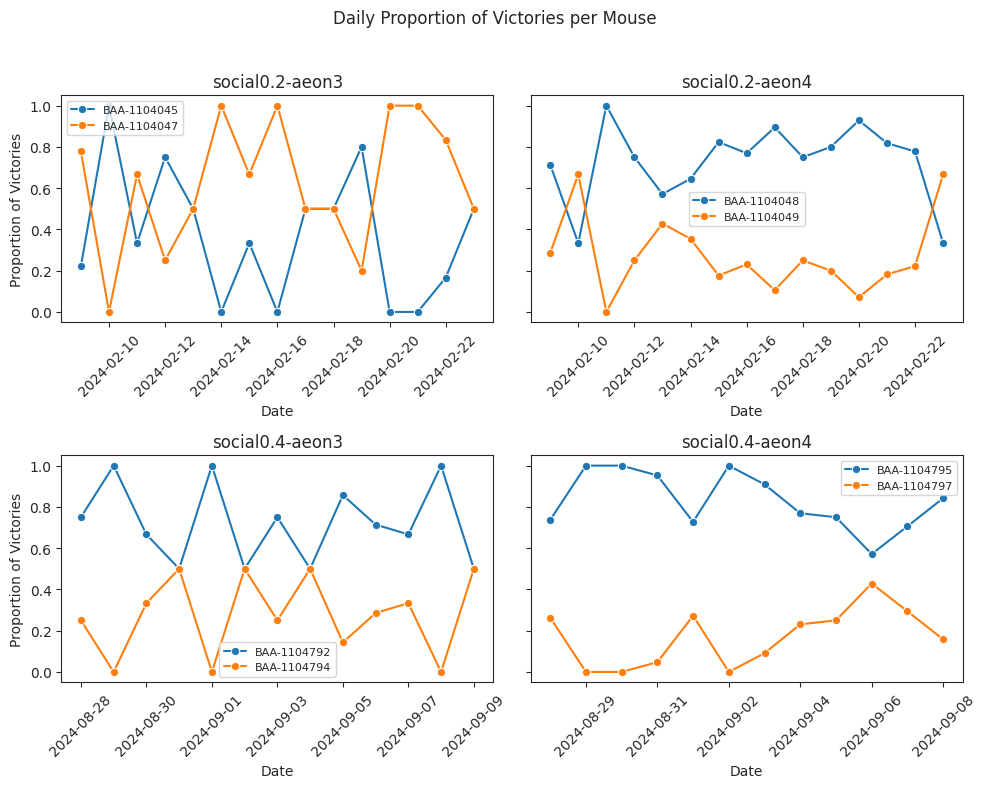

In [ ]:
# NOT SMOOTHED
# Ensure 'end_timestamp' is datetime and extract 'date'
social_retreat_df_all_exps["end_timestamp"] = pd.to_datetime(
    social_retreat_df_all_exps["end_timestamp"]
)
social_retreat_df_all_exps["date"] = social_retreat_df_all_exps["end_timestamp"].dt.date
# Prepare 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing
# Loop through experiments and plot
for i, (exp_name, df_group) in enumerate(
    social_retreat_df_all_exps.groupby("experiment_name", observed=True)
):
    # Compute daily win-counts per mouse
    wins = df_group.groupby(["date", "winner_identity"]).size().unstack(fill_value=0)
    # Turn counts into proportions
    proportions = wins.div(wins.sum(axis=1), axis=0).reset_index()
    # Melt to long form for plotting
    df_long = proportions.melt(
        id_vars="date", var_name="winner_identity", value_name="proportion"
    )
    # Plot in grid
    ax = axes[i]
    sns.lineplot(
        data=df_long,
        x="date",
        y="proportion",
        hue="winner_identity",
        marker="o",
        linewidth=1.5,
        ax=ax,
    )
    ax.set_title(f"{exp_name}")
    ax.set_xlabel("Date")
    ax.tick_params(axis="x", rotation=45)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # every 2 days
    ax.set_ylabel("Proportion of Victories")
    # Add legend per subplot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8)

# Clean layout
plt.suptitle("Daily Proportion of Victories per Mouse")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Smoothed proportion of victories

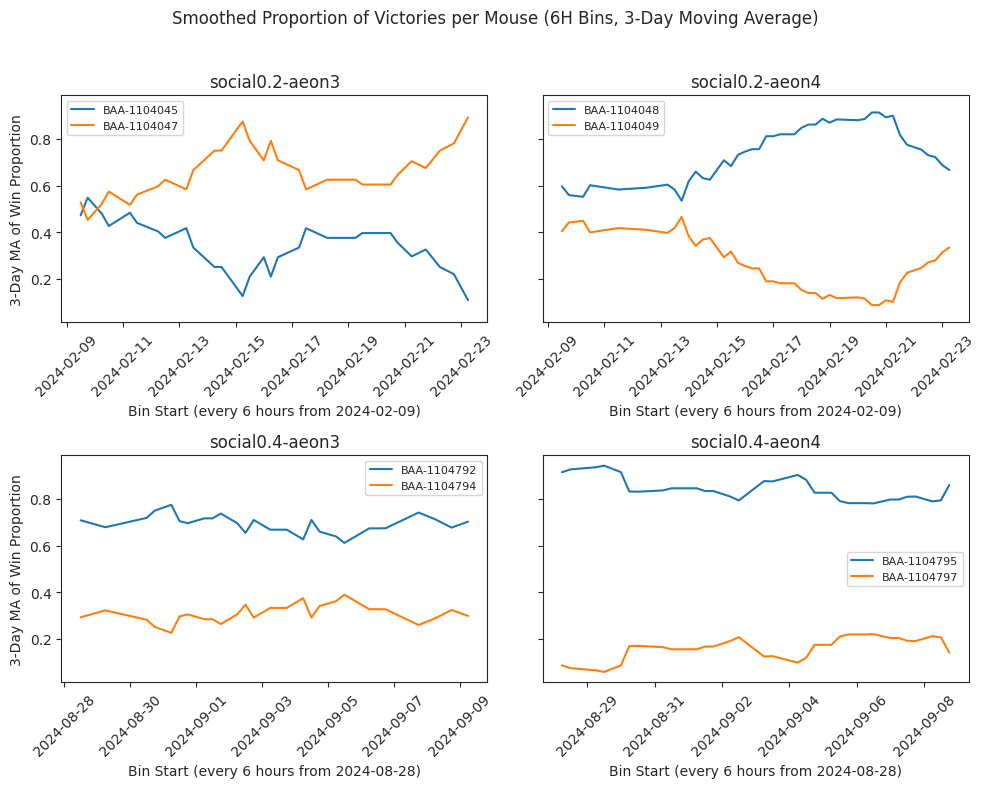

Average number of retreat events per experiment-day: 9.89


In [ ]:
# SMOOTHED
# Parameters
BIN_HOURS = 6  # how many hours per bin (e.g. 6, 8, 10, 12, etc.)
SMOOTH_DAYS = 3  # how many days to smooth over (e.g. 3, 5, 7, etc.)
# Prepare 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing
# Loop through experiments and plot
for i, (exp_name, df_group) in enumerate(
    social_retreat_df_all_exps.groupby("experiment_name", observed=True)
):
    # Compute bin start for each timestamp
    earliest_midnight = df_group["end_timestamp"].dt.normalize().min()
    bin_size = pd.Timedelta(hours=BIN_HOURS)
    offsets = df_group["end_timestamp"] - earliest_midnight
    n_bins = (offsets // bin_size).astype(int)
    df_group["bin_start"] = earliest_midnight + n_bins * bin_size
    # Compute win-counts per bin per mouse
    wins = (
        df_group.groupby(["bin_start", "winner_identity"]).size().unstack(fill_value=0)
    )
    # Drop bins with zero total wins
    wins = wins[wins.sum(axis=1) > 0]
    # Turn counts into proportions
    proportions = wins.div(wins.sum(axis=1), axis=0).reset_index()
    # Melt to long form for plotting
    df_long = proportions.melt(
        id_vars="bin_start", var_name="winner_identity", value_name="proportion"
    )
    # Compute moving average window size (in bins)
    window_size = int((SMOOTH_DAYS * 24) / BIN_HOURS)
    window_size = max(window_size, 1)
    # Apply centered moving average per mouse
    df_long = df_long.sort_values(["winner_identity", "bin_start"])
    df_long["smoothed_prop"] = df_long.groupby("winner_identity")[
        "proportion"
    ].transform(
        lambda s: s.rolling(window=window_size, center=True, min_periods=1).mean()
    )
    # Plot in grid
    ax = axes[i]
    sns.lineplot(
        data=df_long,
        x="bin_start",
        y="smoothed_prop",
        hue="winner_identity",
        # marker=False,
        linewidth=1.5,
        ax=ax,
    )
    ax.set_title(f"{exp_name}")
    ax.set_xlabel(
        f"Bin Start (every {BIN_HOURS} hours from {earliest_midnight.date()})"
    )
    ax.tick_params(axis="x", rotation=45)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # every 2 days
    ax.set_ylabel(f"{SMOOTH_DAYS}‐Day MA of Win Proportion")
    # Add legend per subplot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8)

# Clean layout
plt.suptitle(
    f"Smoothed Proportion of Victories per Mouse ({BIN_HOURS}H Bins, {SMOOTH_DAYS}‐Day Moving Average)"
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Compute average number of retreat events per experiment-day
social_retreat_df_all_exps["start_timestamp"] = pd.to_datetime(
    social_retreat_df_all_exps["start_timestamp"]
)
# Extract day from timestamp
social_retreat_df_all_exps["day"] = social_retreat_df_all_exps[
    "start_timestamp"
].dt.floor("D")
# Count events per (experiment, day)
daily_counts = social_retreat_df_all_exps.groupby(
    ["experiment_name", "day"], observed=True
).size()
# Compute global average
avg_events_per_day = daily_counts.mean()
print(f"Average number of retreat events per experiment-day: {avg_events_per_day:.2f}")


### Manual vs. automated tube test 

To validate our automated approach, we also conducted manual tube tests (adapted from [Fan et al. 2019](https://www.nature.com/articles/s41596-018-0116-4)) before ("pre-social") and after ("post-social") the experiments.

Here we compare manual tube test outcomes with automated dominance rankings derived from retreat behaviours during the experiments, and show that the automated method reliably captures hierarchical relationships over time. 
Specifically, dominant individuals consistently exhibit a higher proportion of victories, both in manual assays and in automated retreat-based rankings.

**Manual tube test outcomes**

| Group            | Subject ID     | Pre-social | Post-social |
|------------------|----------------|------------|-------------|
| social0.2-aeon3  | BAA-1104045    | 2          | 1           |
|                  | BAA-1104047    | 8          | 9           |
| social0.2-aeon4  | BAA-1104048    | 7          | 8           |
|                  | BAA-1104049    | 3          | 2           |
| social0.4-aeon3  | BAA-1104792    | 12         | 13          | 
|                  | BAA-1104794    | 4          | 2           |
| social0.4-aeon4  | BAA-1104795    | 10         | 12          |
|                  | BAA-1104797    | 4          | 3           |


Wilcoxon signed-rank: W = 2.000, p-value = 0.375



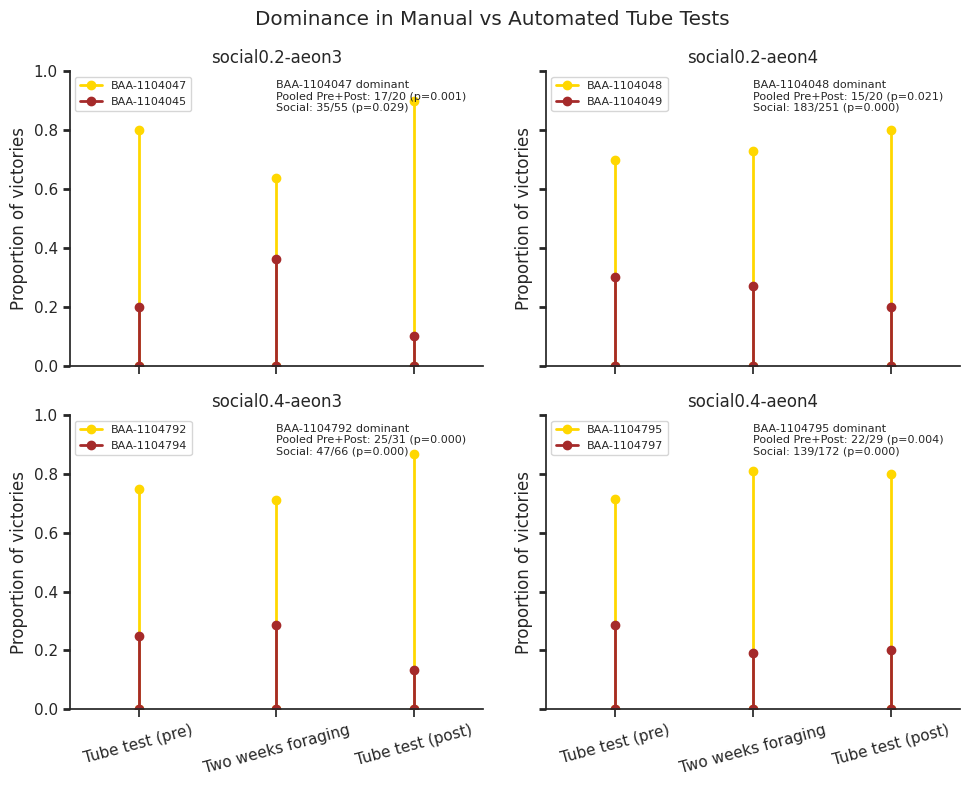

In [ ]:
# Total win counts per subject during social phase
social_counts_df = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)
# Manual tube test data (pre- and post-social)
tube_test_data = {
    "social0.2-aeon3": {
        "BAA-1104045": {"pre": 2, "post": 1},
        "BAA-1104047": {"pre": 8, "post": 9},
    },
    "social0.2-aeon4": {
        "BAA-1104048": {"pre": 7, "post": 8},
        "BAA-1104049": {"pre": 3, "post": 2},
    },
    "social0.4-aeon3": {
        "BAA-1104794": {"pre": 4, "post": 2},
        "BAA-1104792": {"pre": 12, "post": 13},
    },
    "social0.4-aeon4": {
        "BAA-1104795": {"pre": 10, "post": 12},
        "BAA-1104797": {"pre": 4, "post": 3},
    },
}
# Compute per-experiment summary metrics for dominant subject
records = []
for exp, subj_dict in tube_test_data.items():
    soc_counts = social_counts_df.loc[exp]
    total_pre = sum(d["pre"] for d in subj_dict.values())
    total_post = sum(d["post"] for d in subj_dict.values())
    total_soc = soc_counts.sum()
    # Identify dominant by total wins across all phases
    total_wins = {
        subj: subj_dict[subj]["pre"] + soc_counts.get(subj, 0) + subj_dict[subj]["post"]
        for subj in subj_dict
    }
    dominant = max(total_wins, key=total_wins.get)
    # Compute win rates for dominant subject
    pre_rate = subj_dict[dominant]["pre"] / total_pre
    social_rate = soc_counts[dominant] / total_soc
    post_rate = subj_dict[dominant]["post"] / total_post
    baseline_rate = (subj_dict[dominant]["pre"] + subj_dict[dominant]["post"]) / (
        total_pre + total_post
    )
    records.append(
        {
            "experiment": exp,
            "dominant": dominant,
            "pre_rate": pre_rate,
            "social_rate": social_rate,
            "post_rate": post_rate,
            "baseline_rate": baseline_rate,
        }
    )
summary_df = pd.DataFrame(records)

# Test: is social-phase rate higher than pre+post (Wilcoxon signed-rank)
stat, p_value = wilcoxon(summary_df["baseline_rate"], summary_df["social_rate"])
print(f"Wilcoxon signed-rank: W = {stat:.3f}, p-value = {p_value:.3f}\n")

# Per-experiment plotting and binomial tests
x_positions = [0, 1, 2]
x_labels = ["Tube test (pre)", "Two weeks foraging", "Tube test (post)"]
phase_order = ["pre", "social", "post"]
plot_data = []
annotations = []
for experiment, subjects in tube_test_data.items():
    ids = list(subjects.keys())
    pre_scores = {s: subjects[s]["pre"] for s in ids}
    post_scores = {s: subjects[s]["post"] for s in ids}
    soc_counts = social_counts_df.loc[experiment]
    dominant = summary_df.loc[summary_df["experiment"] == experiment, "dominant"].iloc[
        0
    ]
    subordinate = [s for s in ids if s != dominant][0]
    # Win/loss counts
    k_pre = pre_scores[dominant]
    n_pre = k_pre + pre_scores[subordinate]
    k_post = post_scores[dominant]
    n_post = k_post + post_scores[subordinate]
    k_social = soc_counts[dominant]
    n_social = soc_counts.sum()
    # Binomial tests
    k_pool = k_pre + k_post
    n_pool = n_pre + n_post
    p_pool = binomtest(k_pool, n_pool, p=0.5, alternative="greater").pvalue
    p_social = binomtest(k_social, n_social, p=0.5, alternative="greater").pvalue
    # Annotation text
    annotation = (
        f"{dominant} dominant\n"
        f"Pooled Pre+Post: {k_pool}/{n_pool} (p={p_pool:.3f})\n"
        f"Social: {k_social}/{n_social} (p={p_social:.3f})"
    )
    annotations.append((experiment, annotation))
    # Proportions
    proportions = {
        dominant: {
            "pre": k_pre / n_pre,
            "social": k_social / n_social,
            "post": k_post / n_post,
            "color": "gold",
        },
        subordinate: {
            "pre": pre_scores[subordinate] / n_pre,
            "social": soc_counts[subordinate] / n_social,
            "post": post_scores[subordinate] / n_post,
            "color": "brown",
        },
    }
    for subj, vals in proportions.items():
        for phase, x in zip(phase_order, x_positions):
            plot_data.append(
                {
                    "Experiment": experiment,
                    "Subject": subj,
                    "Phase": phase,
                    "X": x,
                    "Y": vals[phase],
                    "Color": vals["color"],
                }
            )

df = pd.DataFrame(plot_data)
# Plotting in 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()
for i, experiment in enumerate([exp["name"] for exp in experiments]):
    ax = axes[i]
    subset = df[df["Experiment"] == experiment]
    # Draw vertical lines with markers
    for subj in subset["Subject"].unique():
        subj_data = subset[subset["Subject"] == subj]
        for _, row in subj_data.iterrows():
            ax.plot(
                [row["X"], row["X"]],
                [0, row["Y"]],
                color=row["Color"],
                marker="o",
                label=subj if row["Phase"] == "pre" else "",
                linewidth=2,
            )
    ax.set_title(experiment)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=15)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion of victories")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="y", direction="out", length=5, width=2)
    # Add annotation
    _, annotation = annotations[i]
    ax.text(
        0.5,
        0.97,
        annotation,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
    )
    # Add legend per subplot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8, loc="upper left")
plt.suptitle("Dominance in Manual vs Automated Tube Tests")
plt.tight_layout()
plt.show()

### Dominance summary plot

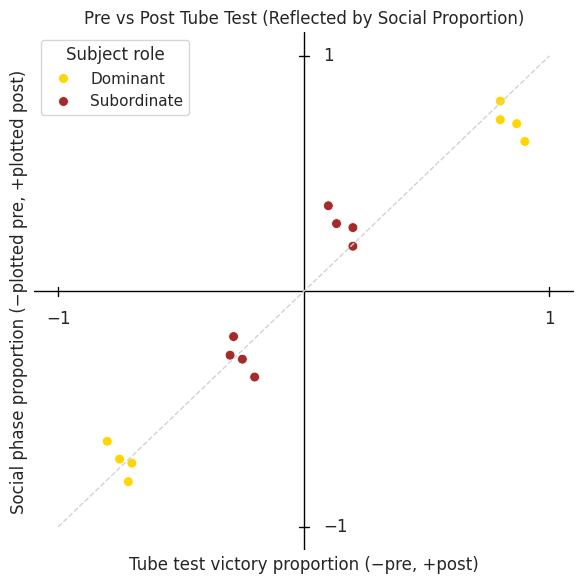

In [ ]:
social_win_proportions = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)
social_win_proportions = social_win_proportions.div(
    social_win_proportions.sum(axis=1), axis=0
)
# Prepare long-form data
plot_rows = []
for experiment, subjects in tube_test_data.items():
    ids = list(subjects.keys())
    pre_scores = {subj: subjects[subj]["pre"] for subj in ids}
    post_scores = {subj: subjects[subj]["post"] for subj in ids}
    pre_dominant = max(pre_scores, key=pre_scores.get)
    post_dominant = max(post_scores, key=post_scores.get)
    if experiment not in social_win_proportions.index:
        raise ValueError(f"No social data for {experiment}")
    social_scores = social_win_proportions.loc[experiment]
    social_dominant = social_scores.idxmax()
    if len({pre_dominant, post_dominant, social_dominant}) != 1:
        raise ValueError(
            f"Inconsistent dominant subject in {experiment}: pre={pre_dominant}, social={social_dominant}, post={post_dominant}"
        )
    dominant = pre_dominant
    subordinate = [s for s in ids if s != dominant][0]
    total_pre = pre_scores[dominant] + pre_scores[subordinate]
    total_post = post_scores[dominant] + post_scores[subordinate]
    social_dom = (
        social_win_proportions.at[experiment, dominant]
        if dominant in social_win_proportions.columns
        else 0
    )
    social_sub = (
        social_win_proportions.at[experiment, subordinate]
        if subordinate in social_win_proportions.columns
        else 0
    )
    for role, subj, color in [
        ("Dominant", dominant, "gold"),
        ("Subordinate", subordinate, "brown"),
    ]:
        plot_rows.append(
            {
                "experiment": experiment,
                "subject": subj,
                "role": role,
                "color": color,
                "x_pre": -pre_scores[subj] / total_pre,
                "x_post": post_scores[subj] / total_post,
                "y_social": -social_win_proportions.at[experiment, subj],
            }
        )

df = pd.DataFrame(plot_rows)
# Create mirrored points for post phase
df_post = df.copy()
df_post["x"] = df_post["x_post"]
df_post["y"] = -df_post["y_social"]
df_pre = df.copy()
df_pre["x"] = df_pre["x_pre"]
df_pre["y"] = df_pre["y_social"]
df_all = pd.concat([df_pre, df_post], ignore_index=True)
# Plot
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=df_all,
    x="x",
    y="y",
    hue="role",
    palette={"Dominant": "gold", "Subordinate": "brown"},
    s=50,
    ax=ax,
)
# Draw quadrant axes
ax.axhline(0, color="black", linewidth=1)
ax.axvline(0, color="black", linewidth=1)
# Draw ticks at ±1
tick_len = 0.02
for t in [-1, 1]:
    ax.plot([t, t], [-tick_len, tick_len], color="black", linewidth=1)  # x-axis ticks
    ax.plot([-tick_len, tick_len], [t, t], color="black", linewidth=1)  # y-axis ticks
# Annotate ±1 labels
ax.text(-1, -0.08, "−1", ha="center", va="top", fontsize=12)
ax.text(1, -0.08, "1", ha="center", va="top", fontsize=12)
ax.text(0.08, -1, "−1", ha="left", va="center", fontsize=12)
ax.text(0.08, 1, "1", ha="left", va="center", fontsize=12)
# Diagonal reference line
ax.plot([-1, 1], [-1, 1], linestyle="--", color="lightgrey", linewidth=1)
# Axis styling
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("Tube test victory proportion (−pre, +post)")
ax.set_ylabel("Social phase proportion (−pre, +post)")
ax.set_title("Pre vs Post Tube Test (Reflected by Social Proportion)")
sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])

plt.legend(title="Subject role")
plt.tight_layout()
plt.show()

### Dominant vs. subordinate at "rich" patch

In [85]:
df = social_patch_df_all_exps.merge(
    social_patchinfo_df_all_exps[
        ["experiment_name", "block_start", "patch_name", "patch_rate"]
    ],
    on=["experiment_name", "block_start", "patch_name"],
    how="left",
).assign(dummy=lambda x: x["patch_name"].str.contains("dummy", case=False))
# Keep only blocks where non-dummy patches have exactly 3 different rates
df = df[
    df.groupby(["experiment_name", "block_start"])["patch_rate"].transform(
        lambda s: s[~df.loc[s.index, "dummy"]].nunique() == 3
    )
]
# Create a ranking only for non-dummy patches
non_dummy_ranks = (
    df[~df["dummy"]]
    .groupby(["experiment_name", "block_start"])["patch_rate"]
    .rank(method="dense")
)
# Add the ranks back to the full dataframe
df["patch_rank"] = np.nan
df.loc[~df["dummy"], "patch_rank"] = non_dummy_ranks
# Assign difficulty (rank 1=hard, rank 3=easy, rank 2=medium)
df["patch_difficulty"] = np.where(
    df["dummy"],
    "dummy",
    np.where(
        df["patch_rank"] == 1, "hard", np.where(df["patch_rank"] == 3, "easy", "medium")
    ),
)
df = df.drop(columns=["patch_rank"])

In [86]:
# Compute social‐win proportions
swp = (
    social_retreat_df_all_exps.groupby(["experiment_name", "winner_identity"])
    .size()
    .unstack(fill_value=0)
)
swp = swp.div(swp.sum(axis=1), axis=0)
# Build the dominance DataFrame in one comprehension
dominance_df = pd.DataFrame(
    [
        {
            "experiment_name": exp,
            "dominant": dom,
            "subordinate": next(s for s in subs if s != dom),
        }
        for exp, subs in tube_test_data.items()
        if exp in swp.index
        # pick the pre‐tube top scorer…
        for dom in [max(subs, key=lambda s: subs[s]["pre"])]
        # …only keep if post‐tube and social‐win agree
        if dom == max(subs, key=lambda s: subs[s]["post"]) == swp.loc[exp].idxmax()
    ]
)
dominance_df

,experiment_name,dominant,subordinate
0,social0.2-aeon3,BAA-1104047,BAA-1104045
1,social0.2-aeon4,BAA-1104048,BAA-1104049
2,social0.4-aeon3,BAA-1104792,BAA-1104794
3,social0.4-aeon4,BAA-1104795,BAA-1104797


#### Relative time in easy patch

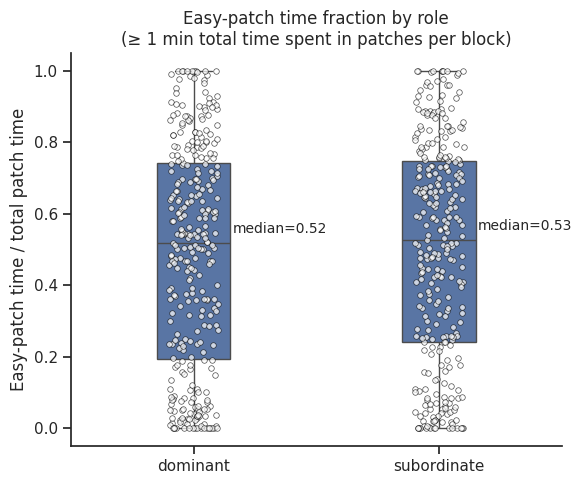

In [100]:
# Compute per‐subject, per‐block easy‐time fraction, but only keep blocks ≥1 min
time_df = (
    df.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "in_patch_time"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .assign(total_time=lambda d: d.sum(axis=1))
    # filter out blocks with < 60 s total patch time
    .loc[lambda d: d["total_time"] >= 60]
    .assign(easy_ratio=lambda d: d["easy"] / d["total_time"])
    .reset_index()
)
# Merge in dominant/subordinate labels and tag role
time_df = time_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)
# Box‐plot of easy_ratio by role
fig, ax = plt.subplots(figsize=(6, 5))
# Draw boxplot with all points
sns.boxplot(
    data=time_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    ax=ax,
    width=0.3,
)
sns.stripplot(
    data=time_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    size=4,
    ax=ax,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    facecolor="white",
    alpha=0.7,
)
sns.despine(ax=ax)
# Axis labels and title
ax.set_title(
    "Easy-patch time fraction by role\n(≥ 1 min total time spent in patches per block)"
)
ax.set_ylabel("Easy-patch time / total patch time")
ax.set_xlabel("")
# Calculate medians
medians = time_df.groupby("role")["easy_ratio"].median()
# Add annotations
for i, role in enumerate(["dominant", "subordinate"]):
    median_val = medians[role]
    ax.text(
        i + 0.35,
        median_val + 0.02,
        f"median={median_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.show()


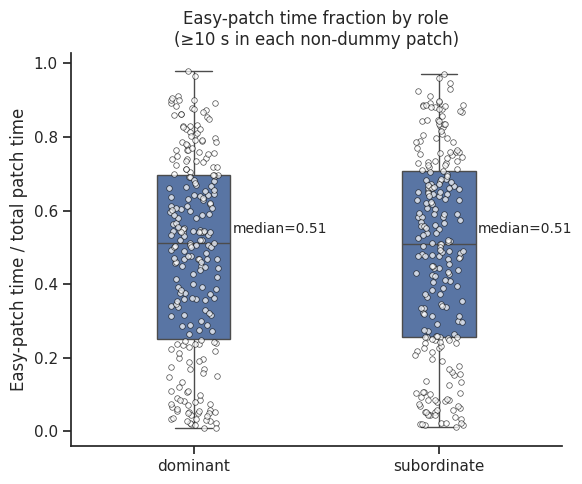

In [99]:
# Get per‐subject, per‐block time by difficulty
time_df = (
    df.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "in_patch_time"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    # drop any block‐subject that didn’t spend ≥10 s in each of hard/medium/easy
    .loc[lambda d: (d[["hard", "medium", "easy"]] >= 10).all(axis=1)]
    .assign(
        total_time=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_time"],
    )
    .reset_index()
)
# Merge in dominant/subordinate and label role
time_df = time_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)
# Box‐plot of easy_ratio by role
fig, ax = plt.subplots(figsize=(6, 5))
# Draw boxplot with all points
sns.boxplot(
    data=time_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    ax=ax,
    width=0.3,
)
sns.stripplot(
    data=time_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    size=4,
    ax=ax,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    facecolor="white",
    alpha=0.7,
)
sns.despine(ax=ax)
# Axis labels and title
ax.set_title("Easy-patch time fraction by role\n(≥10 s in each non-dummy patch)")
ax.set_ylabel("Easy-patch time / total patch time")
ax.set_xlabel("")
# Calculate medians
medians = time_df.groupby("role")["easy_ratio"].median()
# Add annotations
for i, role in enumerate(["dominant", "subordinate"]):
    median_val = medians[role]
    ax.text(
        i + 0.35,
        median_val + 0.02,
        f"median={median_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.show()


#### Relative wheel distance spun in easy patch

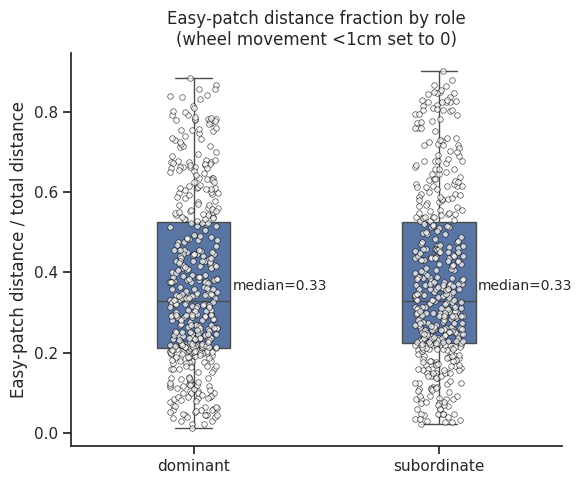

In [96]:
# Compute true traveled distance for each patch‐visit, thresholding <1→0
df2 = (
    df.assign(
        # sum of abs steps = true distance
        traveled=lambda d: d["wheel_cumsum_distance_travelled"].apply(
            lambda arr: np.sum(np.abs(np.diff(arr))) if len(arr) > 1 else 0
        )
    )
    # any tiny (<1) distance becomes 0
    .assign(traveled=lambda d: d["traveled"].mask(d["traveled"] < 1, 0))
)
# Pivot to one row per subject‐block with columns [hard, medium, easy]
dist_df = (
    df2.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "traveled"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .assign(
        total_dist=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_dist"],
    )
    .reset_index()
)
# Merge in dominance & tag role
dist_df = dist_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)
# Box‐plot of easy_ratio by role
fig, ax = plt.subplots(figsize=(6, 5))
# Draw boxplot with all points
sns.boxplot(
    data=dist_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    ax=ax,
    width=0.3,
)
sns.stripplot(
    data=dist_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    size=4,
    ax=ax,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    facecolor="white",
    alpha=0.7,
)
sns.despine(ax=ax)
# Axis labels and title
ax.set_title("Easy‐patch distance fraction by role\n(wheel movement <1cm set to 0)")
ax.set_ylabel("Easy‐patch distance / total distance")
ax.set_xlabel("")
# Calculate medians
medians = dist_df.groupby("role")["easy_ratio"].median()
# Add annotations
for i, role in enumerate(["dominant", "subordinate"]):
    median_val = medians[role]
    ax.text(
        i + 0.35,
        median_val + 0.02,
        f"median={median_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.show()

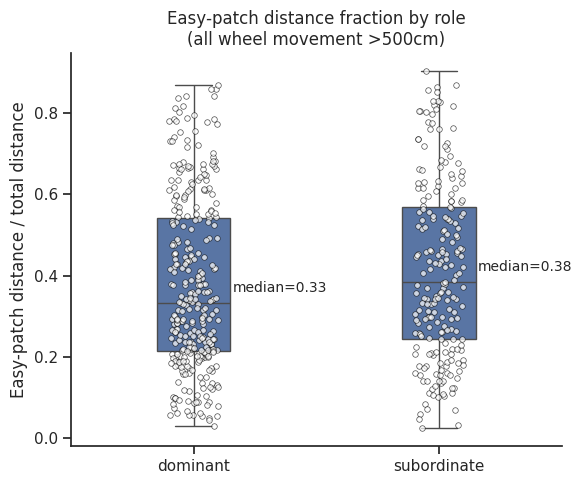

In [98]:
# Compute true traveled distance per patch‐visit, tiny spins → 0
df2 = df.assign(
    traveled=lambda d: d["wheel_cumsum_distance_travelled"].apply(
        lambda arr: np.sum(np.abs(np.diff(arr))) if len(arr) > 1 else 0
    )
).assign(traveled=lambda d: d["traveled"].mask(d["traveled"] < 1, 0))
# Pivot to one row per subject‐block, but only keep rows where hard,medium,easy >5
dist_df = (
    df2.groupby(["experiment_name", "block_start", "subject_name", "patch_difficulty"])[
        "traveled"
    ]
    .sum()
    .unstack("patch_difficulty", fill_value=0)
    .loc[lambda d: (d[["hard", "medium", "easy"]] > 500).all(axis=1)]
    .assign(
        total_dist=lambda d: d.sum(axis=1),
        easy_ratio=lambda d: d["easy"] / d["total_dist"],
    )
    .reset_index()
)
# Merge in dominance & tag role
dist_df = dist_df.merge(dominance_df, on="experiment_name", how="left").assign(
    role=lambda d: np.where(
        d["subject_name"] == d["dominant"], "dominant", "subordinate"
    )
)
# Box‐plot of easy_ratio by role
fig, ax = plt.subplots(figsize=(6, 5))
# Draw boxplot with all points
sns.boxplot(
    data=dist_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    ax=ax,
    width=0.3,
)
sns.stripplot(
    data=dist_df,
    x="role",
    y="easy_ratio",
    order=["dominant", "subordinate"],
    size=4,
    ax=ax,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    facecolor="white",
    alpha=0.7,
)
sns.despine(ax=ax)
# Axis labels and title
ax.set_title("Easy-patch distance fraction by role\n(all wheel movement >500cm)")
ax.set_ylabel("Easy-patch distance / total distance")
ax.set_xlabel("")
# Calculate medians
medians = dist_df.groupby("role")["easy_ratio"].median()
# Add annotations
for i, role in enumerate(["dominant", "subordinate"]):
    median_val = medians[role]
    ax.text(
        i + 0.35,
        median_val + 0.02,
        f"median={median_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.tight_layout()
plt.show()

## Patch preference

Combining position data with foraging patch data, we compute patch preference to quantify how subjects allocate effort across patches with varying reward thresholds. 
Here we compare behaviours across social and solo (post-social) contexts, showing that subjects forage more efficiently and locate richer patches faster when conspecifics are present. 


### Load data

In [ ]:
data = load_experiment_data(
    data_dir=data_dir,
    data_types=["patch", "patchinfo"],
)
patch_df = data["None_patch"]
patch_info_df = data["None_patchinfo"]
block_subject_patch_data_social_combined = patch_df[
    patch_df["period"] == "social"
].copy()
block_subject_patch_data_social_combined.drop(columns=["period"], inplace=True)
block_subject_patch_data_social_dict = patch_df_to_dict(
    block_subject_patch_data_social_combined
)
block_subject_patch_data_post_social_combined = patch_df[
    patch_df["period"] == "postsocial"
].copy()
block_subject_patch_data_post_social_combined.drop(columns=["period"], inplace=True)
block_subject_patch_data_post_social_dict = patch_df_to_dict(
    block_subject_patch_data_post_social_combined
)
block_subject_patch_data_social_first_half_combined = get_first_half_social(
    patch_df
).copy()
block_subject_patch_data_social_first_half_combined.drop(
    columns=["period"], inplace=True
)
block_subject_patch_data_social_first_half_dict = patch_df_to_dict(
    block_subject_patch_data_social_first_half_combined
)
patch_info_dict = patch_info_df_to_dict(patch_info_df)

### Wheel distance spun per block, averaged by the number of subjects

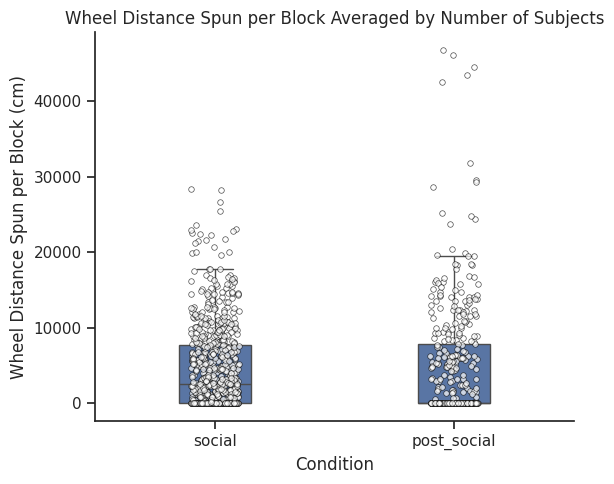

In [108]:
block_subject_patch_data_social_combined["final_wheel_cumsum"] = (
    block_subject_patch_data_social_combined["wheel_cumsum_distance_travelled"].apply(
        lambda x: x[-1] if isinstance(x, np.ndarray) and len(x) > 0 else 0
    )
)
wheel_total_dist_averaged_social = (
    block_subject_patch_data_social_combined.groupby("block_start")[
        "final_wheel_cumsum"
    ].sum()
    / 2
)
wheel_total_dist_averaged_social = wheel_total_dist_averaged_social.reset_index()
block_subject_patch_data_post_social_combined["final_wheel_cumsum"] = (
    block_subject_patch_data_post_social_combined[
        "wheel_cumsum_distance_travelled"
    ].apply(lambda x: x[-1] if isinstance(x, np.ndarray) and len(x) > 0 else 0)
)
wheel_total_dist_averaged_post_social = (
    block_subject_patch_data_post_social_combined.groupby("block_start")[
        "final_wheel_cumsum"
    ]
    .sum()
    .reset_index()
)
wheel_total_dist_averaged_social["condition"] = "social"
wheel_total_dist_averaged_post_social["condition"] = "post_social"
wheel_total_dist_averaged = pd.concat(
    [wheel_total_dist_averaged_social, wheel_total_dist_averaged_post_social]
)
# Draw boxplot with all points
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(
    data=wheel_total_dist_averaged,
    x="condition",
    y="final_wheel_cumsum",
    order=["social", "post_social"],
    ax=ax,
    width=0.3,
    showfliers=False,  # hides outlier dots
)
sns.stripplot(
    data=wheel_total_dist_averaged,
    x="condition",
    y="final_wheel_cumsum",
    order=["social", "post_social"],
    size=4,
    ax=ax,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    facecolor="white",
    alpha=0.7,
)
sns.despine(ax=ax)
# Axis labels and title
ax.set_title("Wheel Distance Spun per Block Averaged by Number of Subjects")
ax.set_ylabel("Wheel Distance Spun per Block (cm)")
ax.set_xlabel("Condition")
plt.tight_layout()
plt.show()


### Patch probabilities by each subject per block

In [ ]:
prob_per_patch_social_first_half_dict = {}
prob_per_patch_social_dict = {}
prob_per_patch_post_social_dict = {}
prob_hard_patch_social_first_half_dict = {}
prob_hard_patch_social_dict = {}
prob_hard_patch_post_social_dict = {}
prob_hard_patch_mean_social_first_half_dict = {}
prob_hard_patch_mean_social_dict = {}
prob_hard_patch_mean_post_social_dict = {}

for exp in experiments:
    exp_name = exp["name"]
    block_subject_patch_data_social_first_half = (
        block_subject_patch_data_social_first_half_dict[exp_name]
    )
    block_subject_patch_data_social = block_subject_patch_data_social_dict[exp_name]
    block_subject_patch_data_post_social = block_subject_patch_data_post_social_dict[
        exp_name
    ]
    patch_info = patch_info_dict[exp_name]
    # Compute patch probabilities
    prob_per_patch_social_first_half_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_social_first_half
    )
    prob_per_patch_social_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_social
    )
    prob_per_patch_post_social_dict[exp_name] = compute_patch_probabilities(
        block_subject_patch_data_post_social
    )
    # Extract hard patch probabilities
    prob_hard_patch_social_first_half_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_social_first_half_dict[exp_name], patch_info
    )
    prob_hard_patch_social_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_social_dict[exp_name], patch_info
    )
    prob_hard_patch_post_social_dict[exp_name] = extract_hard_patch_probabilities(
        prob_per_patch_post_social_dict[exp_name], patch_info
    )
    # Calculate the mean hard patch probability per pellet number
    prob_hard_patch_mean_social_first_half_dict[exp_name] = (
        prob_hard_patch_social_first_half_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )
    prob_hard_patch_mean_social_dict[exp_name] = (
        prob_hard_patch_social_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )
    prob_hard_patch_mean_post_social_dict[exp_name] = (
        prob_hard_patch_post_social_dict[exp_name]
        .groupby("pellet_number")
        .mean(numeric_only=True)
        .reset_index()
    )
# Combine the results
prob_hard_patch_social_first_half_combined = pd.concat(
    prob_hard_patch_social_first_half_dict.values()
)
prob_hard_patch_social_combined = pd.concat(prob_hard_patch_social_dict.values())
prob_hard_patch_post_social_combined = pd.concat(
    prob_hard_patch_post_social_dict.values()
)
prob_hard_patch_mean_social_first_half_combined = (
    prob_hard_patch_social_first_half_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)
prob_hard_patch_mean_social_combined = (
    prob_hard_patch_social_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)
prob_hard_patch_mean_post_social_combined = (
    prob_hard_patch_post_social_combined.groupby("pellet_number")
    .mean(numeric_only=True)
    .reset_index()
)

In [119]:
# Analyse patch probabilities using linear regression model.
model_social_first_half, y_pred_social_first_half = analyze_patch_probabilities(
    prob_hard_patch_mean_social_first_half_combined, "social first half"
)
model_social, y_pred_social = analyze_patch_probabilities(
    prob_hard_patch_mean_social_combined, "social"
)
model_post_social, y_pred_post_social = analyze_patch_probabilities(
    prob_hard_patch_mean_post_social_combined, "post-social"
)

P-value for the social first half slope: 9.258736909825576e-14
social first half model summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     148.4
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           9.26e-14
Time:                        15:26:38   Log-Likelihood:                 93.888
No. Observations:                  35   AIC:                            -183.8
Df Residuals:                      33   BIC:                            -180.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

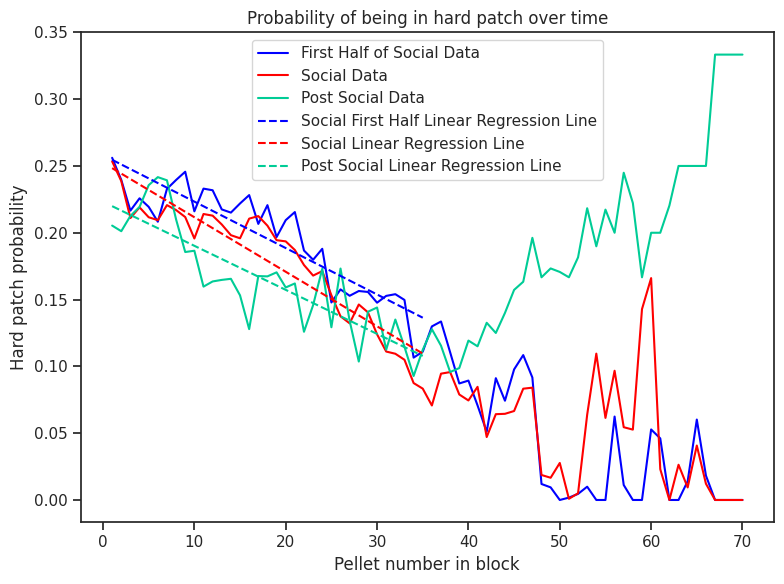

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot raw data lines
sns.lineplot(
    x=prob_hard_patch_mean_social_first_half_combined["pellet_number"],
    y=prob_hard_patch_mean_social_first_half_combined["prob_in_hard_patch"],
    label="First Half of Social Data",
    color="blue",
    ax=ax,
)
sns.lineplot(
    x=prob_hard_patch_mean_social_combined["pellet_number"],
    y=prob_hard_patch_mean_social_combined["prob_in_hard_patch"],
    label="Social Data",
    color="red",
    ax=ax,
)
sns.lineplot(
    x=prob_hard_patch_mean_post_social_combined["pellet_number"],
    y=prob_hard_patch_mean_post_social_combined["prob_in_hard_patch"],
    label="Post Social Data",
    color="#00CC96",
    ax=ax,
)
# Plot regression lines (dashed)
sns.lineplot(
    x=prob_hard_patch_mean_social_first_half_combined["pellet_number"][0:35],
    y=y_pred_social_first_half,
    label="Social First Half Linear Regression Line",
    color="blue",
    linestyle="--",
    ax=ax,
)
sns.lineplot(
    x=prob_hard_patch_mean_social_combined["pellet_number"][0:35],
    y=y_pred_social,
    label="Social Linear Regression Line",
    color="red",
    linestyle="--",
    ax=ax,
)
sns.lineplot(
    x=prob_hard_patch_mean_social_combined["pellet_number"][0:35],
    y=y_pred_post_social,
    label="Post Social Linear Regression Line",
    color="#00CC96",
    linestyle="--",
    ax=ax,
)
# Final layout
ax.set_title("Probability of being in hard patch over time")
ax.set_xlabel("Pellet number in block")
ax.set_ylabel("Hard patch probability")
plt.tight_layout()
plt.show()

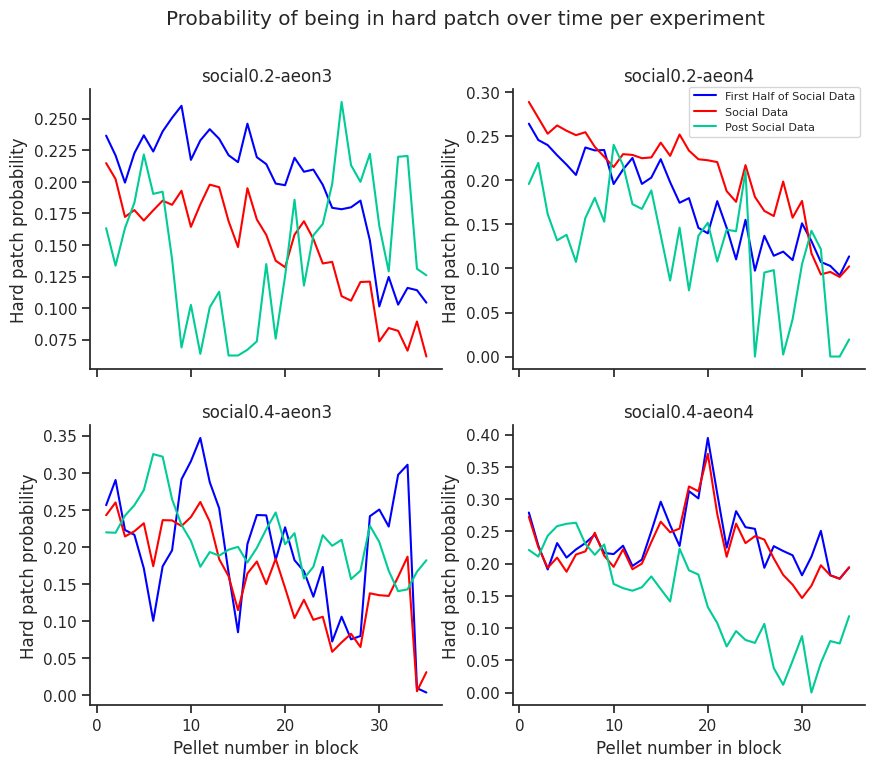

In [173]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
# Iterate over experiments
for i, exp in enumerate(experiments):
    ax = axes[i]
    exp_name = exp["name"]
    # First Half of Social Data
    sns.lineplot(
        x=prob_hard_patch_mean_social_first_half_dict[exp_name]["pellet_number"][0:35],
        y=prob_hard_patch_mean_social_first_half_dict[exp_name]["prob_in_hard_patch"][
            0:35
        ],
        label="First Half of Social Data",
        color="blue",
        ax=ax,
    )
    # Social Data
    sns.lineplot(
        x=prob_hard_patch_mean_social_dict[exp_name]["pellet_number"][0:35],
        y=prob_hard_patch_mean_social_dict[exp_name]["prob_in_hard_patch"][0:35],
        label="Social Data",
        color="red",
        ax=ax,
    )
    # Post Social Data
    sns.lineplot(
        x=prob_hard_patch_mean_post_social_dict[exp_name]["pellet_number"][0:35],
        y=prob_hard_patch_mean_post_social_dict[exp_name]["prob_in_hard_patch"][0:35],
        label="Post Social Data",
        color="#00CC96",
        ax=ax,
    )
    ax.set_title(exp_name)
    ax.set_xlabel("Pellet number in block")
    ax.set_ylabel("Hard patch probability")
    ax.legend().remove()
sns.despine()
# Extract legend handles from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.9, 0.89), fontsize=8)
# Add shared legend to the full figure
fig.suptitle("Probability of being in hard patch over time per experiment")
plt.show()

### Unrewarded vs. standard patches

In the `social0.4` experiments, a fourth "unrewarded" patch on which the pellet dispenser unit was inactive was introduced as a control. 
We compare the foraging wheel activity across patch types and show that subjects spun the wheel significantly more on standard patches where the pellet dispenser unit was active.

In [ ]:
patch_dfs = []
for exp in [exp for exp in experiments if exp["name"].startswith("social0.4")]:
    data = load_experiment_data(experiment=exp, data_dir=data_dir, data_types=["patch"])
    df = data["None_patch"]
    patch_dfs.append(df)
patch_df_s4 = pd.concat(patch_dfs).sort_index()

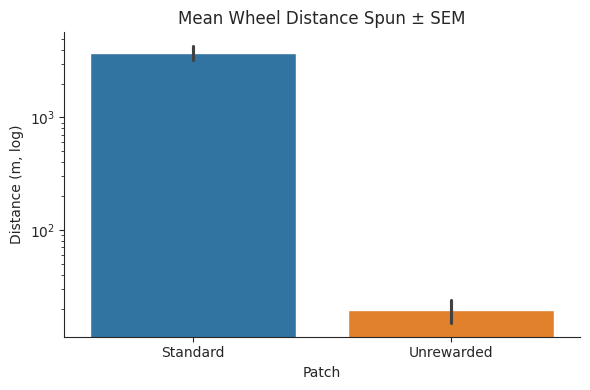

In [25]:
dt_seconds = 0.02  # Wheel sampling interval in seconds
summary = []
# Compute total distance spun per (subject, patch)
for (subject, patch), grp in patch_df_s4.groupby(["subject_name", "patch_name"]):
    total_distance = sum(
        np.asarray(w)[-1] for w in grp["wheel_cumsum_distance_travelled"] if len(w) > 0
    )
    summary.append(
        {"subject": subject, "patch": patch, "distance": total_distance / 100}
    )  # convert to meters
summary_df = pd.DataFrame(summary)
summary_df["patch_type"] = summary_df["patch"].apply(
    lambda p: "Unrewarded" if "Dummy" in p else "Standard"
)
plt.figure(figsize=(6, 4))
sns.barplot(
    data=summary_df,
    x="patch_type",
    y="distance",
    hue="patch_type",
    errorbar="se",
)
plt.yscale("log")
plt.ylabel("Distance (m, log)")
plt.xlabel("Patch")
plt.title("Mean Wheel Distance Spun ± SEM")
sns.despine()
plt.tight_layout()
plt.show()

In [38]:
summary_patch_type_df = (
    summary_df.groupby(["subject", "patch_type"])["distance"].mean().unstack()
)
t_stat, p_val = ttest_rel(
    summary_patch_type_df["Unrewarded"], summary_patch_type_df["Standard"]
)
print(f"Paired t‐statistic = {t_stat:.3f},  p‐value = {p_val:.4f}")
summary_patch_type_df

Paired t‐statistic = -17.706,  p‐value = 0.0004


patch_type,Standard,Unrewarded
subject,,
BAA-1104792,4300.985857,25.288925
BAA-1104794,3847.328388,20.960074
BAA-1104795,3551.048284,24.882764
BAA-1104797,3306.791160,6.401984


## Weight
### Load data

In [ ]:
social_weight_dfs = []
for exp in experiments:
    data = load_experiment_data(
        experiment=exp, data_dir=data_dir, periods=["social"], data_types=["weight"]
    )
    df = data["social_weight"]
    social_weight_dfs.append(df)

social_weight_df_all_exps = pd.concat(social_weight_dfs).sort_index()

### Averaged over time per subject

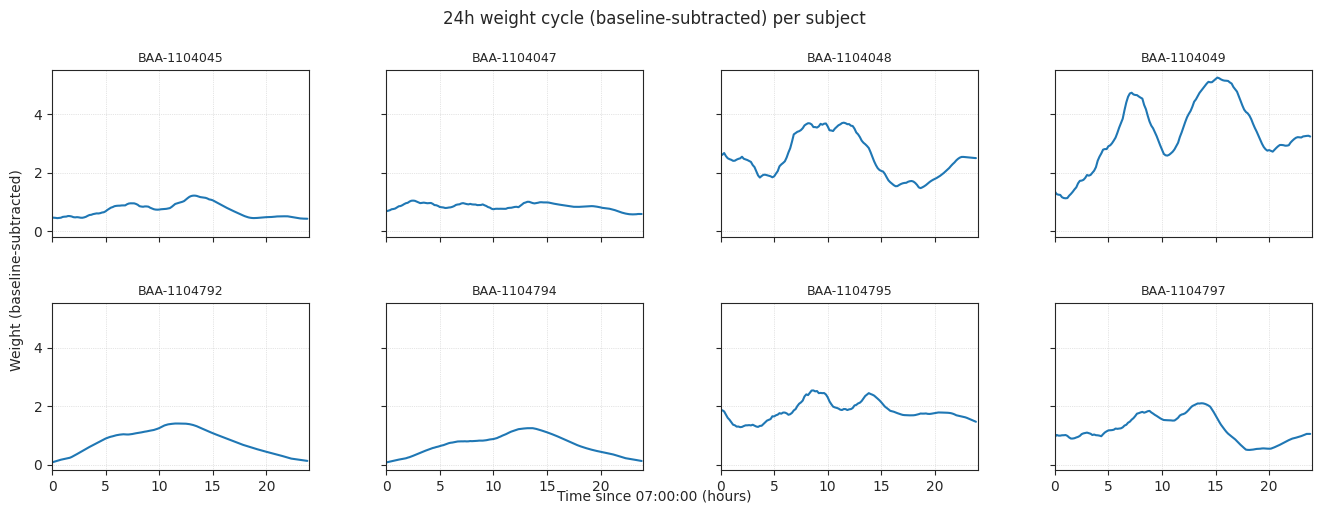

In [ ]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)
# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")
# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)
# Will hold each mouse’s mean‐day
cycle_df = pd.DataFrame(index=cycle_index)
# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()
    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()
    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets
    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()
    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract each mouse’s minimum, then grand‐mean
cycle_df_baselined = cycle_df.subtract(cycle_df.min(skipna=True), axis=1)
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)
# Smooth both mean and SEM with a centered rolling window
window = 20
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()
# Plot each subject's mean-day curve in its own subplot
n_subj = cycle_df_baselined.shape[1]
n_cols = 4  # adjust as needed
n_rows = math.ceil(n_subj / n_cols)
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(3.5 * n_cols, 2.5 * n_rows), sharex=True, sharey=True
)
axes = axes.flatten()
x_hours = cycle_df_baselined.index.total_seconds() / 3600
for i, sid in enumerate(cycle_df_baselined.columns):
    ax = axes[i]
    y = cycle_df_baselined[sid]
    y_smooth = y.rolling(window=window, center=True, min_periods=1).mean()
    ax.plot(x_hours, y_smooth, lw=1.5)
    ax.set_title(sid, fontsize=9)
    ax.set_xlim(0, 24)
    ax.grid(True, linestyle=":", linewidth=0.5)

# Remove any unused axes
for ax in axes[n_subj:]:
    ax.set_visible(False)

fig.suptitle("24h weight cycle (baseline-subtracted) per subject", y=1.02)
fig.text(0.5, 0.04, f"Time since {light_off:02d}:00:00 (hours)", ha="center")
fig.text(0.04, 0.5, "Weight (baseline-subtracted)", va="center", rotation="vertical")
plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.1, left=0.07, right=0.97, top=0.90)
plt.show()

#### Averaged over time and subjects

Baselined by subtracting the minimum of each subject's 24h mean-day curve

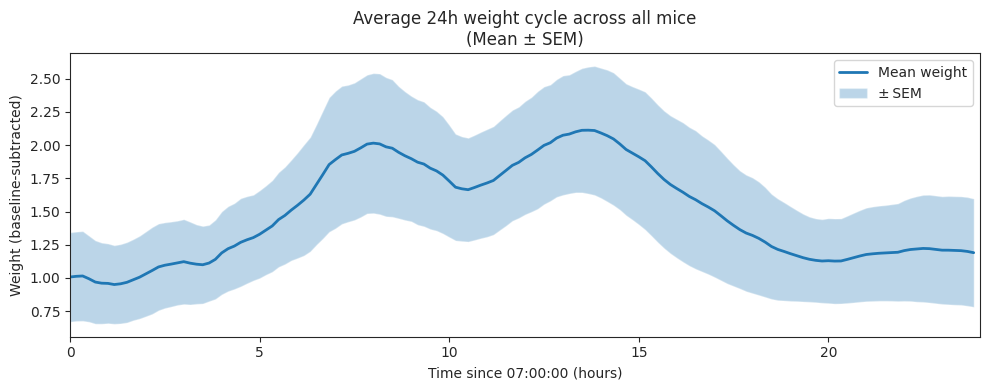

In [ ]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)
# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")
# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)
# Will hold each mouse’s mean‐day
cycle_df = pd.DataFrame(index=cycle_index)

# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()
    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()
    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets
    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()
    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract each mouse’s minimum, then grand‐mean
cycle_df_baselined = cycle_df.subtract(cycle_df.min())
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)
# Smooth both mean and SEM with a centered rolling window
window = 20
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()
# Plot mean ± SEM
plt.figure(figsize=(10, 4))
x_hours = cycle_df_baselined.index.total_seconds() / 3600
plt.plot(x_hours, grand_mean_smooth, lw=2, label="Mean weight")
plt.fill_between(
    x_hours,
    grand_mean_smooth - sem_smooth,
    grand_mean_smooth + sem_smooth,
    alpha=0.3,
    label="± SEM",
)
plt.xlabel(f"Time since {light_off:02d}:00:00 (hours)")
plt.ylabel("Weight (baseline-subtracted)")
plt.title("Average 24h weight cycle across all mice\n(Mean ± SEM)")
plt.xlim(0, 24)
plt.legend()
plt.tight_layout()
plt.show()

Baselined by subtracting the minimum of each subject's _smoothed_ 24h mean-day curve

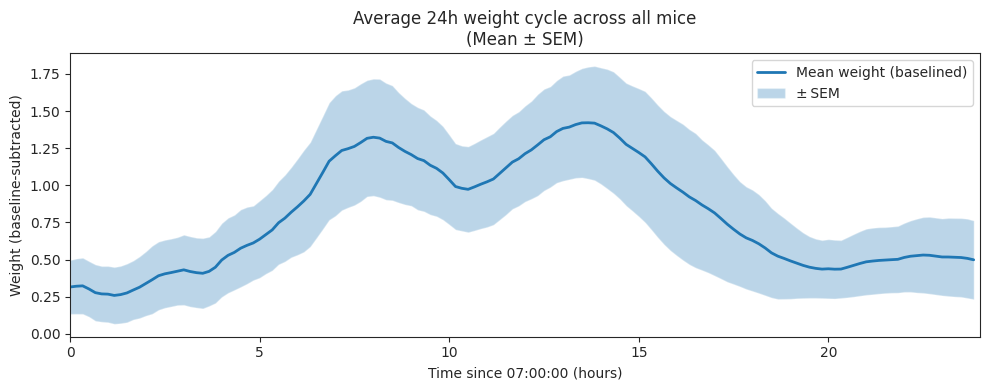

In [ ]:
# Flatten the “array-of-arrays” df into a long DataFrame
records = []
for _, row in social_weight_df_all_exps.iterrows():
    ts = pd.to_datetime(row["timestamps"])
    w = np.asarray(row["weight"], dtype=float)
    sids = row["subject_id"]
    for t, weight, sid in zip(ts, w, sids):
        records.append({"timestamp": t, "subject_id": sid, "weight": weight})

df = pd.DataFrame.from_records(records)
df = df.sort_values(["subject_id", "timestamp"])
# Drop rows where subject_id is shorter than 11 characters, removes some erroneous entries
df = df[df["subject_id"].str.len() >= 11].reset_index(drop=True)
# Parameters & 24 h cycle grid
sampling_freq = "10min"  # resample interval
# Choose any date at 08:00 to define “day zero”
anchor = pd.Timestamp(f"2020-01-01 {light_off:02d}:00:00")
# Build the 24 h cycle index
n_steps = int(pd.Timedelta("1D") / pd.Timedelta(sampling_freq))
cycle_index = pd.timedelta_range(start=0, periods=n_steps, freq=sampling_freq)
# Will hold each mouse’s mean‐day (unsmoothed)
cycle_df = pd.DataFrame(index=cycle_index)
# Loop over each mouse, resample, fold into 24 h, average days
for sid, grp in df.groupby("subject_id"):
    # Series of weight vs time
    ser = grp.set_index("timestamp")["weight"].sort_index()
    # Collapse any exact-duplicate timestamps
    ser = ser.groupby(level=0).mean()
    # Resample into bins anchored at 08:00, then interpolate
    ser_rs = ser.resample(sampling_freq, origin=anchor).mean().interpolate()
    # Convert each timestamp into its offset (mod 24 h) from the anchor
    offsets = (ser_rs.index - anchor) % pd.Timedelta("1D")
    ser_rs.index = offsets
    # Average across all days for each offset
    daily = ser_rs.groupby(ser_rs.index).mean()
    # Align to uniform cycle grid
    cycle_df[sid] = daily.reindex(cycle_index)

# Baseline‐subtract using each subject’s smoothed minimum
window = 20  # keep same smoothing window for per‐subject curves
# Smooth each column (i.e., each subject’s 24 h curve)
cycle_df_smooth = cycle_df.rolling(window=window, center=True, min_periods=1).mean()
# Find the minimum of each subject’s smoothed curve
minima_smooth = cycle_df_smooth.min()  # series indexed by subject_id
# Subtract that baseline from the UNSMOOTHED cycle for each subject
cycle_df_baselined = cycle_df.subtract(minima_smooth, axis=1)
# Now compute grand‐mean and SEM (over baselined, unsmoothed curves)
grand_mean = cycle_df_baselined.mean(axis=1)
sem = cycle_df_baselined.sem(axis=1)
# Smooth both grand‐mean and SEM for plotting
grand_mean_smooth = grand_mean.rolling(window=window, center=True, min_periods=1).mean()
sem_smooth = sem.rolling(window=window, center=True, min_periods=1).mean()
# Plot mean ± SEM
plt.figure(figsize=(10, 4))
x_hours = cycle_df_baselined.index.total_seconds() / 3600
plt.plot(x_hours, grand_mean_smooth, lw=2, label="Mean weight (baselined)")
plt.fill_between(
    x_hours,
    grand_mean_smooth - sem_smooth,
    grand_mean_smooth + sem_smooth,
    alpha=0.3,
    label="± SEM",
)
plt.xlabel(f"Time since {light_off:02d}:00:00 (hours)")
plt.ylabel("Weight (baseline‐subtracted)")
plt.title("Average 24h weight cycle across all mice\n(Mean ± SEM)")
plt.xlim(0, 24)
plt.legend()
plt.tight_layout()
plt.show()